In [23]:
# import PIL
import PIL
from glob import glob
%matplotlib inline
# Import libraries
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf

batch_size = 32
x_train1 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('image/cage/*')])/255
x_train2 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('image/trump/*')])/255
x_valid1 = x_train1[-batch_size:]
x_valid2 = x_train2[-batch_size:]
x_train1 = x_train1[:-batch_size]
x_train2 = x_train2[:-batch_size]
print(x_train1.shape)
print(x_train2.shape)

(286, 64, 64, 3)
(344, 64, 64, 3)


In [24]:
tf.__version__

'1.11.0'

In [25]:
tf.test.gpu_device_name()

''

In [26]:
def plot_imgs(imgs, n, title=None):
    fig, axs = plt.subplots(1, n, figsize=(n, 2))
    if n==1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    if title is not None:
        fig.suptitle(title)
    plt.show()

In [27]:
class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def build_model(self):
        image_size = self.image_size
        self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
        self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
        self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
        self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')
        def encoder(encoder_input):
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                # TODO: Complete encoder
                hidden = encoder_input
                hidden = tf.reshape(hidden, [-1, image_size*image_size*3])
                hidden = tf.layers.dense(inputs=hidden, units=512, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=256, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=16, activation=tf.nn.relu)
            return hidden
          
        self.encoded_embedding1 = encoder(self.encoder_input1)
        self.encoded_embedding2 = encoder(self.encoder_input2)
        
        def decoder(encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                # TODO: Complete decoder 
                hidden = encoded_embedding
                hidden = tf.layers.dense(inputs=hidden, units = 64, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 256, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 512, activation=tf.nn.relu)
                outputs = tf.layers.dense(inputs=hidden, units = image_size*image_size*3, name = 'recon_logits')
                outputs = tf.reshape(outputs, [-1, image_size, image_size, 3])
                return outputs
              
        outputs1 = decoder(self.encoded_embedding1, 'decoder1')
        outputs2 = decoder(self.encoded_embedding2, 'decoder2')
        
        ################## define cost function and optimizer ##################        
        if self.cost_function == 'mse':
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
        elif self.cost_function == 'bce':
            self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
            self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
            self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output1, 
                                                            logits=outputs1))
            self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output2, 
                                                            logits=outputs2))
        else:
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))
            self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        self.cost = self.cost1 + self.cost2    
        self.lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
        if self.optimizer == 'adadelta':
            self.optimize_op = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optimize_op = tf.train.AdamOptimizer(self.lr, beta1=0.5).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optimize_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in range(n_epoch):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.lr: 5e-5,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
#             print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}, time_passed: {}'.format(
#                   epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2), time()-t))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
#             print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}, time_passed: {}'.format(
#                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2), time()-t))
            valid_costs_per_epoch.append(np.mean(valid_costs))
            
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('epoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})

In [28]:
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=0.0001, cost_function='abs')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

epoch: 50


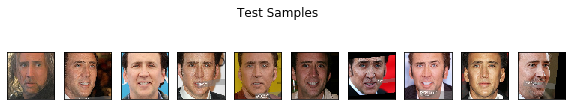

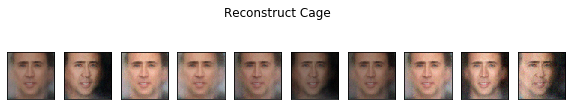

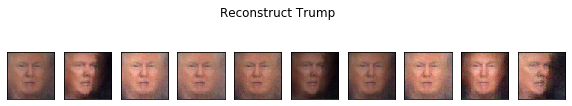

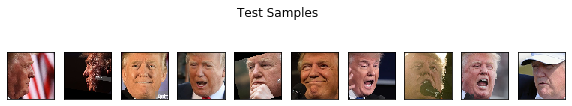

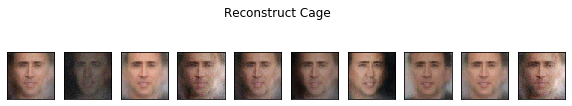

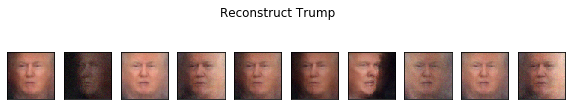

epoch: 100


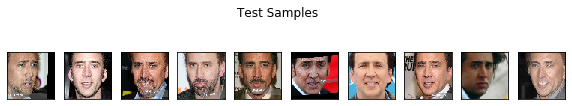

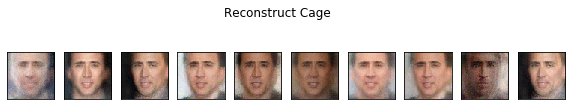

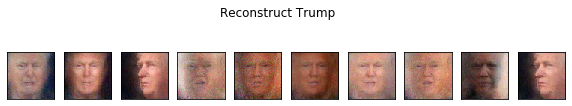

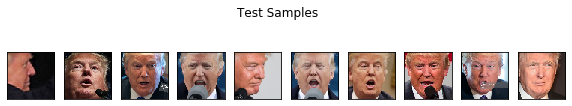

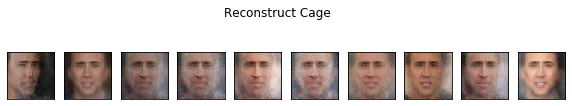

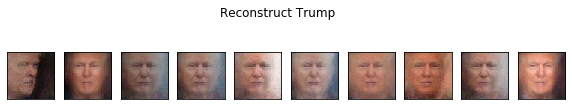

epoch: 150


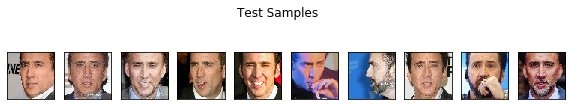

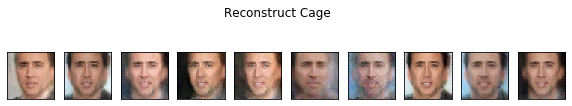

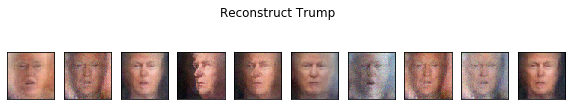

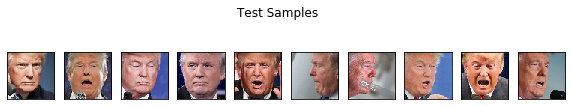

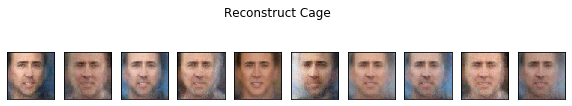

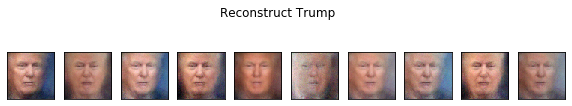

epoch: 200


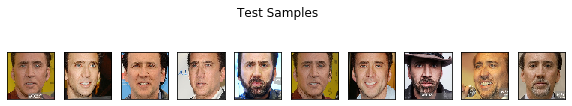

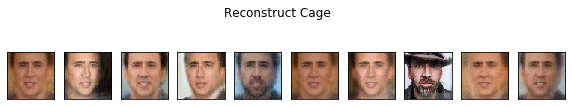

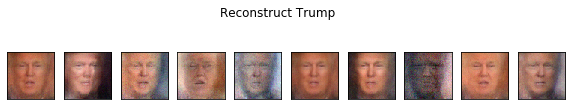

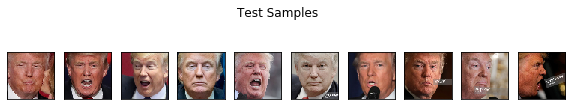

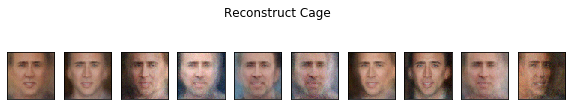

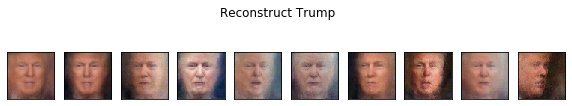

epoch: 250


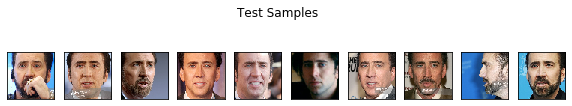

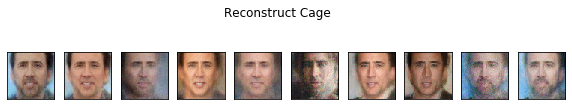

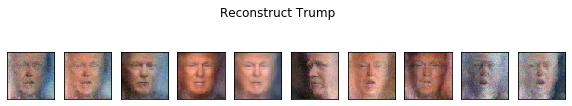

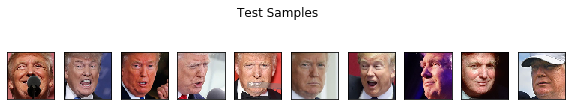

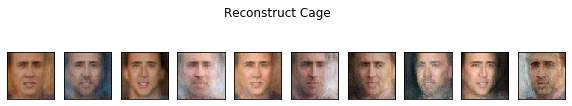

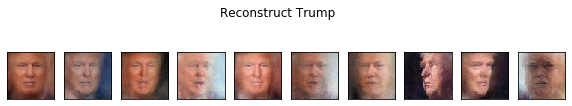

epoch: 300


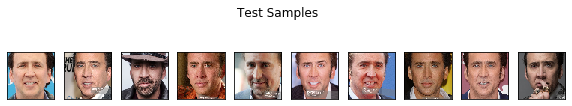

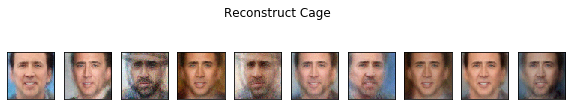

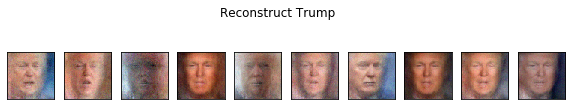

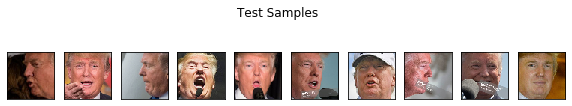

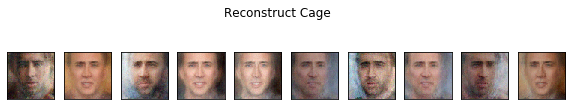

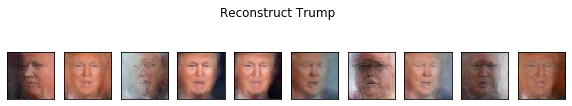

epoch: 350


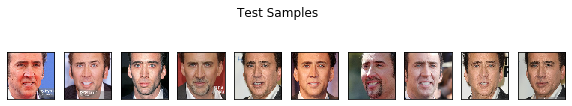

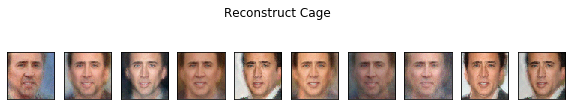

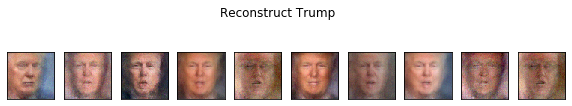

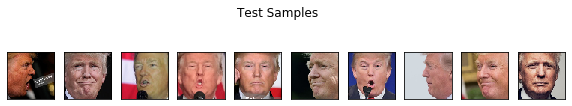

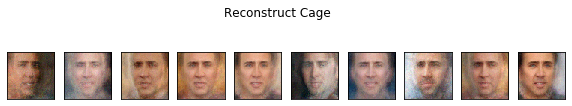

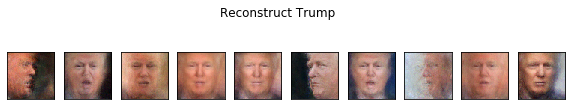

early stop at 381 epoch


In [29]:
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=20)

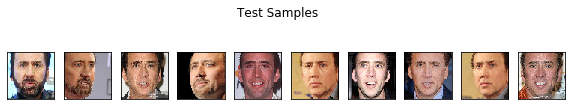

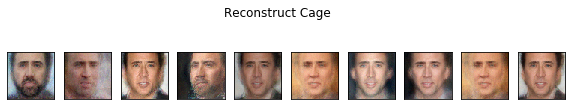

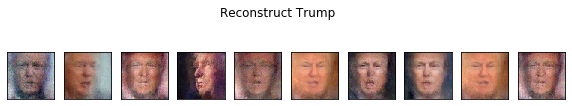

In [32]:
n = 10
orig_imgs = x_valid1[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
    
plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

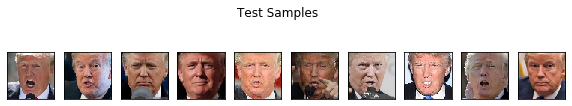

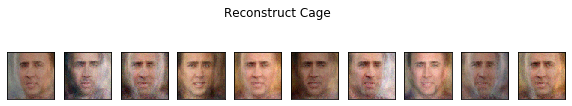

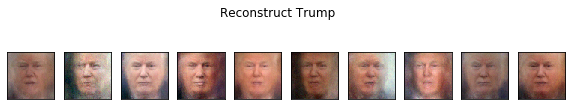

In [33]:
n = 10
orig_imgs = x_valid2[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')


<font size="5"><b>application:</b></font>

由autoencoder變形成為Recursive Autoencoder，每個字都透過Autoencoder reconstruct，並且每個字reconstruct的input會由過去每個字reconstruct的summary加上目前input word來達到Recursive，並學習文字的dependency和structure。
1. Word Embeddings

2. Machine Translation

3. Document Clustering

4. Sentiment Analysis

5. Paraphrase Detection<br>
https://www.doc.ic.ac.uk/~js4416/163/website/nlp/

<font size="5"><b>what I have learned:</b></font>
1. 使用dense做encoder或decoder時，若直接把channel>1的資料當成input，會使得學習到的資料只有同個位置不同chanel的資料，若是想要學習周圍資訊，需要reshape成channel==1的input再餵進去dense！

2. encoder的濃縮資料的dimension學習重要feature的過程中，neuron units數的減少可「自己設定」，通常會用2的指數遞減是為了配合GPU計算效能，和原始圖片的dimension沒有關係，